### Figure 2 in Stan and Mantripragada (2023)
The code tests whether there is overfitting. \
It will compute losses and plots the loss curves for training and validation. \
The overfitting analysis is done at a single grid point (lat: 0; lon: 160E).

In [1]:
import numpy as np
import xarray as xr
import proplot as pplt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,DepthwiseConv1D,subtract
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
pplt.rc.update({'meta.width':1, 'ticklabelweight':'bold', 'axeslabelweight':'bold','titleweight':'bold','fontname':'Noto Sans','fontsize':24,'titlesize':26})

In [3]:
### Define Custom Functions

In [4]:
def filtwghts_lanczos(nwt, filt_type, fca, fcb):
	
    """
    Calculates the Lanczos filter weights.
    
    Parameters
    ----------
    nwt : int
        The number of weights.
    filt_type : str
        The type of filter. Must be one of 'low', 'high', or 'band'.
    fca : float
        The cutoff frequency for the low or band filter.
    fcb : float
        The cutoff frequency for the high or band filter.
    
    Returns
    -------
    w : ndarray
        The Lanczos filter weights.
    
    Notes
    -----
    The Lanczos filter is a type of sinc filter that is truncated at a specified frequency.
    This function implements a Lanczos filter in the time domain.
    """	
	
    pi = np.pi
    k = np.arange(-nwt, nwt+1)

    if filt_type == 'low':
        w = np.zeros(nwt*2+1)
        w[:nwt] = ((np.sin(2 * pi * fca * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt))
        w[nwt+1:] = ((np.sin(2 * pi * fca * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt))
        w[nwt] = 2 * fca
    elif filt_type == 'high':
        w = np.zeros(nwt*2+1)
        w[:nwt] = -1 * (np.sin(2 * pi * fcb * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt)
        w[nwt+1:] = -1 * (np.sin(2 * pi * fcb * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt)
        w[nwt] = 1 - 2 * fcb
    else:
        w1 = np.zeros(nwt*2+1)
        w1[:nwt] = (np.sin(2 * pi * fca * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt)
        w1[nwt+1:] = (np.sin(2 * pi * fca * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt)
        w1[nwt] = 2 * fca
        w2 = np.zeros(nwt*2+1)
        w2[:nwt] = (np.sin(2 * pi * fcb * k[:nwt]) / (pi * k[:nwt])) * np.sin(pi * k[:nwt] / nwt) / (pi * k[:nwt] / nwt)
        w2[nwt+1:] = (np.sin(2 * pi * fcb * k[nwt+1:]) / (pi * k[nwt+1:])) * np.sin(pi * k[nwt+1:] / nwt) / (pi * k[nwt+1:] / nwt)
        w2[nwt] = 2 * fcb
        w = w2 - w1
		
    return w

wgths = filtwghts_lanczos(90,'band',1/90,1/30)
wgths = xr.DataArray(wgths, dims=['window'])

### Enter latitude and longitude

In [5]:
lat, lon = 0, 160

### Load the NOAA interpolated data. 
The NOAA interpolated data is downloaded from: https://downloads.psl.noaa.gov/Datasets/interp_OLR/olr.day.mean.nc 

In [6]:
# NOAA interpolated daily mean OLR
olriFile = '/homes/rmantrip/testPyISV/olr.day.i.mean.nc'
olri = xr.open_dataset(olriFile).sel(lat=lat,lon=lon,method='nearest').sel(time=slice('1980',None)).olr

### Get the years to split the dataset into training, validation, and testing. 

In [7]:
startTrain, endTrain, startVal, endVal, startTest, endTest = '1988', '2012', '2013', '2014', '2015', '2016'

### Calculate climatology based only on the training period. This will avoid test data leakages or bias.
### Calculate unfiltered anomalies and band pass filtered anomalies 

In [8]:
########################## OLR ##########################
# Calculate the climatology

olri_clim = olri.sel(time=slice(startTrain, endTrain)).groupby("time.dayofyear").mean("time")

# Calculate the anomalies

olri_anom = olri.groupby("time.dayofyear") - olri_clim

# Calculate 30-90-day band pass Lanczos filterd olr anomalies 

nwgths = 90 # The filter uses 181 (nwgths*2+1) weights
tpa = 30 # Time period: 30-day
tpb = 90 # Time period: 90-day
wgths = filtwghts_lanczos(nwgths,'band',1/tpb,1/tpa)
wgths = xr.DataArray(wgths, dims=['window'])

olri_bpf = olri_anom.rolling(time=len(wgths), center=True).construct('window').dot(wgths)

In [9]:
#Split the data to train and test 

xtrain = olri_anom.sel(time=slice(startTrain, endTrain)).values
ytrain = olri_bpf.sel(time=slice(startTrain, endTrain)).values

xval = olri_anom.sel(time=slice(startVal, endVal)).values
yval = olri_bpf.sel(time=slice(startVal, endVal)).values

In [10]:
# Introduce new axis in order to satisy the input dimension requirements to a CNN model

xtrain1 = np.expand_dims(xtrain,axis=(0,2))
ytrain1 = np.expand_dims(ytrain,axis=(0,2))

xval1 = np.expand_dims(xval,axis=(0,2))
yval1 = np.expand_dims(yval,axis=(0,2))

print(xtrain1.shape)
print(xval1.shape)

(1, 9132, 1)
(1, 730, 1)


In [11]:
#Model configuration

no_epochs = 1000
verbosity = 0

inputs = Input(shape=(None,1),batch_size=1,name='input_layer')
smoth1 = DepthwiseConv1D(kernel_size=90,padding='same',use_bias=False,activation='linear')(inputs)
diff = subtract([inputs, smoth1])
smoth2 = DepthwiseConv1D(kernel_size=30,padding='same',use_bias=False,activation='linear')(diff)
model = Model(inputs=inputs, outputs=smoth2)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(1, None, 1)]       0           []                               
                                                                                                  
 depthwise_conv1d (DepthwiseCon  (1, None, 1)        90          ['input_layer[0][0]']            
 v1D)                                                                                             
                                                                                                  
 subtract (Subtract)            (1, None, 1)         0           ['input_layer[0][0]',            
                                                                  'depthwise_conv1d[0][0]']       
                                                                                              

2023-03-19 20:40:13.263436: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
history = model.fit(xtrain1,ytrain1,epochs=no_epochs,validation_data=(xval1, yval1),verbose=verbosity)

### Figure 2

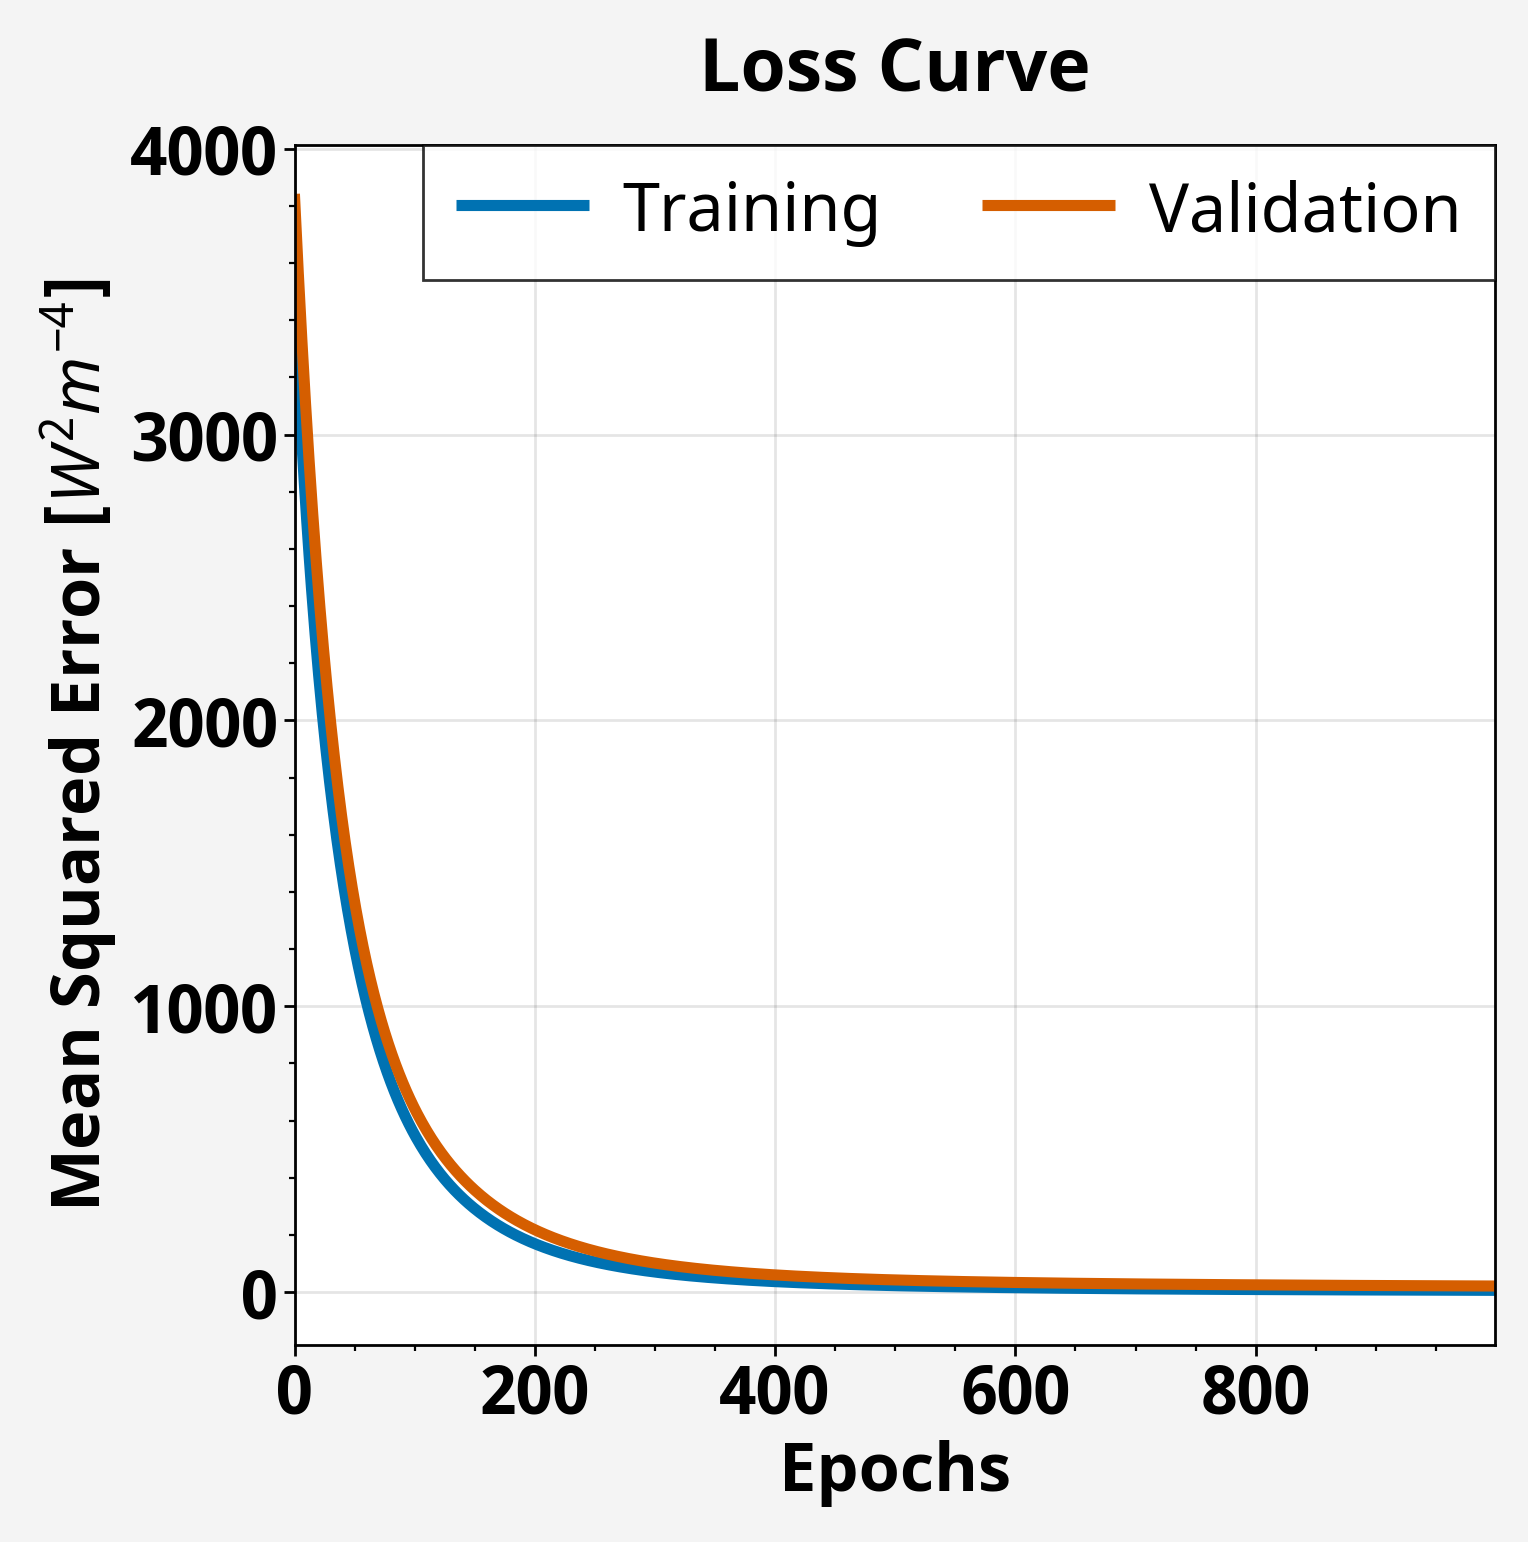

In [15]:
fig = pplt.figure(refwidth=6,refheight=6,suptitle='Loss Curve')
ax = fig.subplot(xlabel='Epochs', ylabel='Mean Squared Error [$W^2m^{-4}$]')
ax.plot(history.history['loss'], lw=4,label='Training')
ax.plot(history.history['val_loss'], lw=4,label='Validation')
ax.legend(loc='ur')
fig.savefig('Fig2.png',dpi=150)